In [ ]:
# default_exp engine.point_process

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Emitter distribution

> Definition of the class used to simulate random emitter positions and intensities

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from decode_fish.funcs.utils import *

In [ ]:
#export
class PointProcessUniform(Distribution):
    """
    This class is part of the generative model and uses the probability local_rate to generate sample locations on the voxel grid.  
    For each emitter we then sample x-,y- and z-offsets uniformly in the range [-0.5,0.5] to get continuous locations.
    Intensities are sampled from a gamma distribution torch.distirubtions.gamma(int_conc, int_rate) which is shifted by int_loc.
    Together with the microscope.scale and the PSF this results in the overall brightness of an emitter.
    
    Args:
        local_rate torch.tensor . shape(BS, C, H, W, D): Local rate
        int_conc=0., int_rate=1., int_loc (float): parameters of the intensity gamma distribution
        sim_iters (int): instead of sampling once from local_rate, we sample sim_iters times from local_rate/sim_iters. 
            This results in the same average number of sampled emitters but allows us to sample multiple emitters within one voxel.

    """
    def __init__(self, int_conc=0., int_rate=1., int_loc=1., sim_iters: int = 5, n_channels=1, sim_z=True, slice_rec=True, codebook=None, int_option=1, code_weight=None, device='cuda'):

        assert sim_iters >= 1
        self.sim_iters = sim_iters
        self.int_conc = int_conc
        self.int_rate = int_rate
        self.int_loc = int_loc
        self.n_channels = n_channels
        self.sim_z = sim_z
        self.slice_rec = slice_rec
        self.int_option = int_option
        self.device = device
        
        self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None
        
        if self.codebook is not None:
            self.n_channels = self.codebook.shape[-1]
            self.code_weight = code_weight.to(self.device) if code_weight is not None else torch.ones(len(self.codebook)).to(self.device)
        
    def sample(self, local_rate, from_code_book=True):

        res_ = [self._sample(local_rate.to(self.device)/self.sim_iters, from_code_book) for i in range(self.sim_iters)]
        locations = torch.cat([i[0] for i in res_], dim=0)
        x_offset = torch.cat([i[1] for i in res_], dim=0)
        y_offset = torch.cat([i[2] for i in res_], dim=0)
        z_offset = torch.cat([i[3] for i in res_], dim=0)
        intensities = torch.cat([i[4] for i in res_], dim=0)
        codes = torch.cat([i[6] for i in res_], dim=0) if from_code_book else None
        
        return list(locations.T), x_offset, y_offset, z_offset, intensities, res_[0][5], codes

    def _sample(self, local_rate, from_code_book):

        output_shape = list(local_rate.shape)
        local_rate = torch.clamp(local_rate,0.,1.)
        locations = D.Bernoulli(local_rate).sample()
        n_emitter = int(locations.sum().item())
        x_offset = D.Uniform(low=-0.5, high=0.5).sample(sample_shape=[n_emitter]).to(self.device)
        y_offset = D.Uniform(low=-0.5, high=0.5).sample(sample_shape=[n_emitter]).to(self.device)
        z_offset = D.Uniform(low=-0.5, high=0.5).sample(sample_shape=[n_emitter]).to(self.device)
        
        if self.slice_rec: # For slice rec we use a larger range
            z_offset *= 2
        
#         intensities = torch.zeros([n_emitter, self.n_channels]).to(self.device)
        if self.int_option == 1:
            intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter, self.n_channels]).to(self.device) + self.int_loc 
        elif self.int_option == 2:
            intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter, 1]).to(self.device) + self.int_loc 
            intensities = intensities.repeat_interleave(self.n_channels, 1)
        elif self.int_option == 3:
            intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter, 1]).to(self.device) + self.int_loc 
            intensities = intensities.repeat_interleave(self.n_channels, 1)
            int_noise = D.Uniform(low=.7, high=1.5).sample(sample_shape=intensities.shape).to(self.device)
            intensities *= int_noise
            
        # If 2D data z-offset is 0
        if not self.sim_z:
            z_offset *= 0
    
        locations = locations.nonzero(as_tuple=False)

        if self.n_channels > 1:
            code_draw = None
            if from_code_book:
                
                code_draw = torch.multinomial(self.code_weight, num_samples=n_emitter, replacement=True)
                ch_draw = self.codebook[code_draw].to(self.device, dtype=torch.float32)

            else:

                m_draw = torch.multinomial(torch.ones([n_emitter,self.n_channels])/self.n_channels, 1, replacement=False)
                ch_draw = torch.zeros(intensities.shape).to(self.device, dtype=torch.float32)
                ch_draw.scatter_(index=m_draw.to(self.device), dim=1, value=1)
                
            intensities = intensities.to(self.device) * ch_draw.to(self.device)
            output_shape.insert(1, self.n_channels)
            
        return locations, x_offset, y_offset, z_offset, intensities, tuple(output_shape), code_draw
    

def list_to_locations(locations, output_shape):
    tmp =torch.zeros(output_shape, device=locations[0].device)
    coord = torch.stack(locations).T
    #incase you have multiple emitter present
    for i in coord: tmp[tuple(i)] += 1
    return tmp

In [ ]:
from decode_fish.funcs.exp_specific import *
codebook, targets = get_mop_codebook()
# code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

In [ ]:
codebook = np.concatenate([codebook, np.eye(22)], 0)
code_weight = torch.ones(len(codebook))
code_weight[-22:] *= 3

In [ ]:
# codebook = None # torch.tensor(code_ref, dtype=torch.bool)
point_process = PointProcessUniform(int_conc=3, int_rate=1, int_loc=1, sim_iters=1, n_channels=22, codebook=codebook, int_option=1, code_weight=code_weight)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(local_rate = torch.ones([2,3,48,48]).cuda()*.3)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


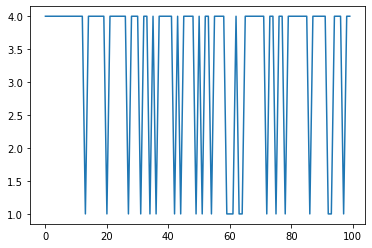

In [ ]:
tra = ints_3d + 0
tra[tra.nonzero(as_tuple=True)] = 1
plt.plot(cpu(tra).sum(-1)[:100])

In [ ]:
# export
def get_phased_ints(ints, ch_cols, n_cols):
    
    col_inds = []
    for i in range(n_cols):
        col_inds.append(torch.where(torch.tensor(ch_cols)==i)[0].cuda()) # Get indices of the different colors
        col_inds[i][-1] = 0 # Set last index to 0 because it won't phase
        
    nonz_inds = ints.nonzero()
    phased_ints = torch.zeros_like(ints)
    phased_inds = torch.zeros_like(nonz_inds) 
    
    # Loop over colors and each pos in the col_indices. Set the phased indices to the next value 
    for c in range(n_cols):
        for n in range(len(col_inds[c]) - 1):
            idx = torch.where(nonz_inds[:,1] == col_inds[c][n])[0]
            phased_inds[idx] = torch.stack([nonz_inds[idx][:,0], torch.ones(len(idx), dtype=torch.int32).cuda() * (col_inds[c][n+1])], 1)
            
    phased_ints[tuple([phased_inds[:,0], phased_inds[:,1]])] += ints[tuple([nonz_inds[:,0], nonz_inds[:,1]])]
    phased_ints[:,0] = 0.
    
    return phased_ints

In [ ]:
ch_cols = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
phased_ints = get_phased_ints(ints_3d, ch_cols, 2)

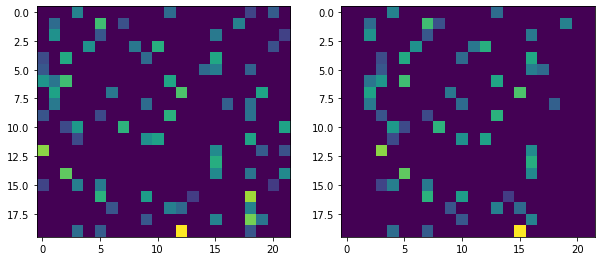

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cpu(ints_3d)[:20])
plt.subplot(122)
plt.imshow(cpu(phased_ints)[:20])

In [ ]:
torch.save([locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes], '../data/sim_var_code_class5.pt')

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
